# Neural Machine Translation: RNN with GRU and Attention Mechanism Comparison with SAN BERT

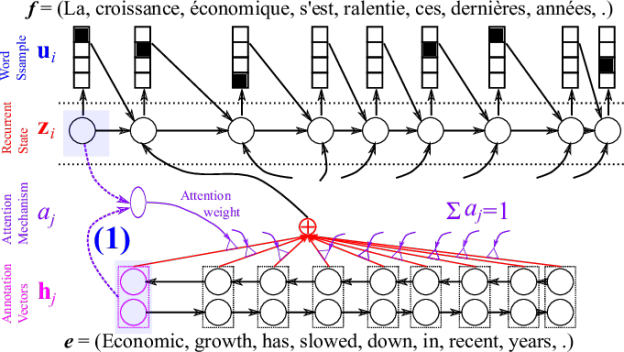

### What is Attention?

Attention is an interface between the encoder and decoder that provides the decoder with information from every encoder hidden state. With this setting, the model is able to selectively focus on useful parts of the input sequence and hence, learn the alignment between them. This helps the model to cope effectively with long input sentences .

In [1]:
!pip install -q chart-studio
# !pip install -q tensorflow

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import time
import string

import chart_studio.plotly
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
#%plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
print("TF version " + tf.__version__)

TF version 2.4.0-rc0


### As in case of any NLP task, after reading the input file, we perform the basic cleaning and preprocessing as follows:

**The Dataset :** We need a dataset that contains English sentences and their Portuguese translations which can be freely downloaded from this [link](http://www.manythings.org/anki/). Download the file fra-eng.zip and extract it. On each line, the text file contains an English sentence and its French translation, separated by a tab.

In [10]:
file_path = '/Documents/Repos/Spring_23/DS_6050/por.txt' # please set the path according to your system

In [14]:
lines = open('por.txt', encoding='UTF-8').read().strip().split('\n')
lines[5000:5010]

['Will it rain?\tSerá que chove?\tCC-BY 2.0 (France) Attribution: tatoeba.org #8918600 (CK) & #8930552 (JGEN)',
 'Wish me luck.\tDeseje-me sorte.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2254917 (CK) & #872788 (alexmarcelo)',
 "Won't you go?\tVocê não vai?\tCC-BY 2.0 (France) Attribution: tatoeba.org #241051 (CK) & #6212788 (bill)",
 'Write in ink.\tEscreva à tinta.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258764 (CM) & #7351595 (alexmarcelo)',
 'Write in ink.\tEscreva a tinta.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258764 (CM) & #7351606 (alexmarcelo)',
 'Write to Tom.\tEscreva para o Tom.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2240357 (CK) & #5985551 (Ricardo14)',
 'Years passed.\tPassaram os anos.\tCC-BY 2.0 (France) Attribution: tatoeba.org #282197 (CK) & #977841 (alexmarcelo)',
 'Years passed.\tAnos se passaram.\tCC-BY 2.0 (France) Attribution: tatoeba.org #282197 (CK) & #2324530 (Matheus)',
 'You amuse me.\tVocê me diverte.\tCC-BY 2.0 (France) Attributio

In [15]:
print("total number of records: ",len(lines))

total number of records:  168903


In [16]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits) # Set of all digits

### Function to preprocess English sentence

In [17]:
def preprocess_eng_sentence(sent):
    '''Function to preprocess English sentence'''
    sent = sent.lower() # lower casing
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.translate(remove_digits) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

### Function to preprocess Portuguese sentence

In [18]:
def preprocess_port_sentence(sent):
    '''Function to preprocess Portuguese sentence'''
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    #sent = re.sub("[२३०८१५७९४६]", "", sent) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

### Generate pairs of cleaned English and Portuguese sentences with start and end tokens added.

In [19]:
# Generate pairs of cleaned English and Portuguese sentences
sent_pairs = []
for line in lines:
    sent_pair = []
    eng = line.rstrip().split('\t')[0]
    port = line.rstrip().split('\t')[1]
    eng = preprocess_eng_sentence(eng)
    sent_pair.append(eng)
    port = preprocess_port_sentence(port)
    sent_pair.append(port)
    sent_pairs.append(sent_pair)
sent_pairs[5000:5010]

[['<start> will it rain <end>', '<start> Será que chove <end>'],
 ['<start> wish me luck <end>', '<start> Desejeme sorte <end>'],
 ['<start> wont you go <end>', '<start> Você não vai <end>'],
 ['<start> write in ink <end>', '<start> Escreva à tinta <end>'],
 ['<start> write in ink <end>', '<start> Escreva a tinta <end>'],
 ['<start> write to tom <end>', '<start> Escreva para o Tom <end>'],
 ['<start> years passed <end>', '<start> Passaram os anos <end>'],
 ['<start> years passed <end>', '<start> Anos se passaram <end>'],
 ['<start> you amuse me <end>', '<start> Você me diverte <end>'],
 ['<start> you are late <end>', '<start> Você está atrasado <end>']]

### Create a class to map every word to an index and vice-versa for any given vocabulary.

In [20]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [21]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### Tokenization and Padding

In [22]:
def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)
    
    # Vectorize the input and target languages
    
    # English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]
    
    # Marathi sentences
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [23]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(lines))

### Creating training and validation sets using an 80-20 split

In [24]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state = 101)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(152012, 152012, 16891, 16891)

### Hyperparameters

In [25]:
EPOCHS = 10
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 100
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

We'll be using GRUs instead of LSTMs as we only have to create one state and implementation would be easier.

### Create GRU units

In [26]:
def gru(units):

    return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')


### The next step is to define the encoder and decoder network.

The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the GRU.

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with a token appended at the beginning.

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

Create encoder and decoder objects from their respective classes.

In [29]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

### Define the optimizer and the loss function.

In [30]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [32]:
def calculate_accuracy(target, prediction):
    # Convert prediction probabilities to binary values
    predicted_labels = tf.argmax(prediction, axis=1)
    
    # Cast target to int64
    target = tf.cast(target, tf.int64)
    
    # Compare predicted labels with target labels
    correct_predictions = tf.equal(predicted_labels, target)
    
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

In [33]:
def calculate_validation_accuracy(validation_input, validation_target):
    total_accuracy = 0
    total_samples = 0

    for (inp, targ) in zip(validation_input, validation_target):
        # Perform inference on the validation input
        predictions = model2.predict(inp)
        predicted_labels = tf.argmax(predictions, axis=1)

        # Compare predicted labels with target labels
        correct_predictions = tf.equal(predicted_labels, targ)

        # Calculate accuracy for the current batch
        batch_accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

        batch_samples = inp.shape[0]

        # Accumulate accuracy and sample count for the entire validation dataset
        total_accuracy += batch_accuracy * batch_samples
        total_samples += batch_samples

    # Calculate the average validation accuracy
    validation_accuracy = total_accuracy / total_samples

    return validation_accuracy


### Training the Model

In [37]:
for epoch in range(EPOCHS):
    start = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_accuracy = 0
    total_val_accuracy = 0

    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        accuracy = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)

            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

                loss += loss_function(targ[:, t], predictions)
                accuracy += calculate_accuracy(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        batch_accuracy = (accuracy / int(targ.shape[1]))

        total_loss += batch_loss
        total_accuracy += batch_accuracy

        variables = encoder.variables + decoder.variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                                         batch,
                                                                         batch_loss.numpy(),
                                                                         batch_accuracy.numpy()))

    average_loss = total_loss / N_BATCH
    average_accuracy = total_accuracy / N_BATCH

    # Calculate validation accuracy
    val_accuracy = calculate_validation_accuracy(input_tensor_val, target_tensor_val)  

    total_val_accuracy += val_accuracy

    # saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f} Accuracy {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                    average_loss.numpy(),
                                                                                    average_accuracy.numpy(),
                                                                                    val_accuracy.numpy()))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.0695 Accuracy 0.0000
Epoch 1 Batch 100 Loss 1.1576 Accuracy 0.0286
Epoch 1 Batch 200 Loss 1.0033 Accuracy 0.0386
Epoch 1 Batch 300 Loss 1.0210 Accuracy 0.0491
Epoch 1 Batch 400 Loss 0.9445 Accuracy 0.0531
Epoch 1 Batch 500 Loss 0.9578 Accuracy 0.0640
Epoch 1 Batch 600 Loss 0.9000 Accuracy 0.0634
Epoch 1 Batch 700 Loss 0.7824 Accuracy 0.0640
Epoch 1 Batch 800 Loss 0.8168 Accuracy 0.0651
Epoch 1 Batch 900 Loss 0.7804 Accuracy 0.0680


2023-05-08 04:05:03.522963: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2023-05-08 04:05:03.590478: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2023-05-08 04:05:03.594548: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 960).
2023-05-08 04:05

Epoch 1 Batch 1000 Loss 0.7730 Accuracy 0.0731
Epoch 1 Batch 1100 Loss 0.6870 Accuracy 0.0714
Epoch 1 Batch 1200 Loss 0.7546 Accuracy 0.0814
Epoch 1 Batch 1300 Loss 0.7169 Accuracy 0.0797
Epoch 1 Batch 1400 Loss 0.7274 Accuracy 0.0803
Epoch 1 Batch 1500 Loss 0.5826 Accuracy 0.0909


NameError: name 'model2' is not defined

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   nb vvnn

### Restoring the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Inference setup and testing:

In [ ]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        sentence = sentence + inp_lang.idx2word[i] + ' '
    sentence = sentence[:-1]
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


### Function to predict (translate) a randomly selected test point


In [ ]:
def predict_random_val_sentence():
    actual_sent = ''
    k = np.random.randint(len(input_tensor_val))
    random_input = input_tensor_val[k]
    random_output = target_tensor_val[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print('Input: {}'.format(sentence[8:-6]))
    print('Predicted translation: {}'.format(result[:-6]))
    for i in random_output:
        if i == 0:
            break
        actual_sent = actual_sent + targ_lang.idx2word[i] + ' '
    actual_sent = actual_sent[8:-7]
    print('Actual translation: {}'.format(actual_sent))
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]

    # use plotly to generate the heat map
    trace = go.Heatmap(z = attention_plot, x = sentence, y = result, colorscale='greens')
    data=[trace]
    iplot(data)


In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

In [ ]:
predict_random_val_sentence()

## Implementing the Transformer Model: BERT

#### Required packages

In [34]:
!pip install -q transformers

In [35]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers

from tokenizers import BertWordPieceTokenizer
from transformers import TFBertModel

/Users/laurenodonnell/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



### TPU Detection
Note, this is currently not in use given the type of instance selected. We can run it, but only 1 accelerator will be detected. 

In [36]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of accelerators:  1


### Preparing the Model Layers
BERT consists of at least one embedding layers, 6 encoder layers, 6 decoder layers, and at least one classification layer. BERT models are pretrained. BERT happens to include Portuguese in its pretraining, thank goodness. 

In [26]:
def bert_model(max_length):
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    
    embedding = encoder(input_ids, attention_mask=None)
    
    pooling = tf.keras.layers.GlobalAveragePooling1D()(embedding.last_hidden_state)
    normalization = tf.keras.layers.BatchNormalization(axis=1)(pooling)
    dropout = tf.keras.layers.Dropout(0.1)(normalization)
    out = tf.keras.layers.Dense(35, activation="sigmoid", name="final_output_bert")(dropout)
    
    #model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
    #                       outputs=out)
    model = tf.keras.Model(inputs=input_ids, outputs=out)

    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.000001)
    metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

In [27]:
if max_length_inp > max_length_targ:
    max_length = max_length_inp
else:
    max_length = max_length_targ

In [28]:
with strategy.scope():
    model2 = bert_model(max_length)
    
model2.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37)]              0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             37, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

### Model Training

In [33]:
history2 = model2.fit(
    x=input_tensor_train,
    y=target_tensor_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    use_multiprocessing=True,
    validation_data=(input_tensor_val, target_tensor_val)
)

Epoch 1/10
1521/1521 [==============================] - ETA: 0s - loss: 985327.6875 - accuracy: 0.1577 - false_negatives: 475679.0000 - false_positives: 1553585.0000

2023-05-08 01:01:33.533811: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-08 01:01:33.793857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1521/1521 [==============================] - 113s 74ms/step - loss: 985327.6250 - accuracy: 0.1577 - false_negatives: 475679.0000 - false_positives: 1553585.0000 - val_loss: 1064006.2500 - val_accuracy: 0.1765 - val_false_negatives: 56298.0000 - val_false_positives: 150456.0000
Epoch 2/10
1521/1521 [==============================] - 97s 64ms/step - loss: 1003214.1250 - accuracy: 0.1582 - false_negatives: 477151.0000 - false_positives: 1543359.0000 - val_loss: 1093496.1250 - val_accuracy: 0.1739 - val_false_negatives: 55846.0000 - val_false_positives: 154738.0000
Epoch 3/10
1521/1521 [==============================] - 96s 63ms/step - loss: 1021205.5625 - accuracy: 0.1574 - false_negatives: 477583.0000 - false_positives: 1539586.0000 - val_loss: 1100254.1250 - val_accuracy: 0.1640 - val_false_negatives: 56938.0000 - val_false_positives: 152681.0000
Epoch 4/10
1521/1521 [==============================] - 98s 64ms/step - loss: 1039920.1875 - accuracy: 0.1576 - false_negatives: 475988.0000 

### Visualizations

Model Accuracy

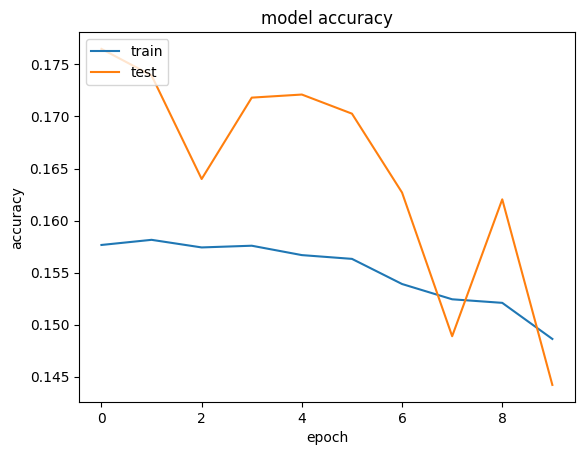

In [37]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model Loss

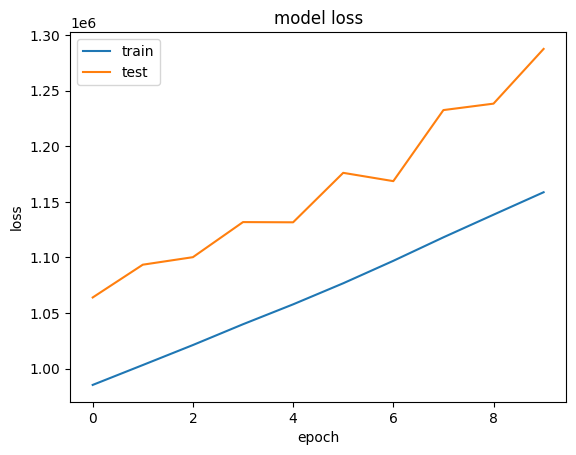

In [39]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()